[Draft]

# Capstone notebook: Classification of Stockholm neighborhoods using Foursquare data
Oxana Falk, July 2019

Let's get all the packages that are going to be used in this assigment:

In [129]:
!pip install beautifulsoup4
!pip install lxml
!pip install requests
from bs4 import BeautifulSoup
import requests
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
# convert an address into latitude and longitude values
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values




# Matplotlib and associated plotting modules
!pip install matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# map rendering library
!pip install folium
import folium

# library to handle JSON files
import json

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

import xml.etree.ElementTree as et 

print("Done!")

Done!


Let's scrape a table from Wikipedia that contains information about the metro stations in Stockholm:

In [630]:
source=requests.get('https://sv.wikipedia.org/w/index.php?title=Lista_%C3%B6ver_tunnelbanestationer_i_Stockholm&oldid=46033661').text
soup = BeautifulSoup(source,'lxml')
table=soup.find('table',{'class':'sortable wikitable'})
table_rows = table.find_all('tr')
res = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        res.append(row)

df = pd.DataFrame(res, columns=["Station", "Line", "Year", "Distance", "Municipality", "Type", "Longitude", "Latitude"])

Let's download the list of Foursquare's main and lower level categories originally downloaded from https://developer.foursquare.com/docs/resources/categories but for now stored in my Github repository:

In [802]:
foursquare_cat=pd.read_csv('https://raw.githubusercontent.com/OxanaFalk/Coursera_Capstone/master/Foursquare_categories_20190718.txt')
type(foursquare_cat)
#foursquare_cat.head()

pandas.core.frame.DataFrame

In [753]:
#url="https://github.com/OxanaFalk/Coursera_Capstone/blob/master/Foursquare_categories_20190718.csv"
#c=pd.read_csv(url)

In [834]:
df.head(100)

,Station,Line,Year,Distance,Municipality,Type,Longitude,Latitude
0,Slussen,Grön,1950,"1,5",Stockholms kommun,Betongstation,18.072327,59.319493
1,Medborgarplatsen,Grön,1950,"2,1",Stockholms kommun,Betongstation,18.073550,59.314342
2,Skanstull,Grön,1950,"2,7",Stockholms kommun,Betongstation,18.076229,59.307852
3,Gullmarsplan,Grön,1950,"3,8",Stockholms kommun,"Ytstation, delvis överbyggd av betong",18.080768,59.299114
4,Skärmarbrink,Grön,1950,"4,5",Stockholms kommun,Ytstation,18.090440,59.295366
5,Blåsut,Grön,1950,"5,1",Stockholms kommun,Ytstation,18.091061,59.290242
6,Sandsborg,Grön,1950,"5,7",Stockholms kommun,Ytstation,18.092382,59.284785
7,Skogskyrkogården,Grön,1950,"6,5",Stockholms kommun,Ytstation,18.095501,59.279194
8,Tallkrogen,Grön,1950,"7,5",Stockholms kommun,Ytstation,18.085326,59.271140
9,Gubbängen,Grön,1950,"8,2",Stockholms kommun,Ytstation,18.082036,59.262879


Let's create a new dataframe where:
* Only opened och functioning stations are left (i.e. I remove Kymlinge that was never opened)
* All columns that are not going to be used are skipped (i.e. I keep only the station name, longitude and latitude)
* Dublicates are removed (in the original table there are some stations that are represented on both lines but since the fact that those stations have the same name and coordinates and lines are not of interest for this project, I'll keep only one copy of those)
* Information about previous names is removed since it's not relevant for this assigment

In [862]:
df1=df[df['Year'].astype(str).str.isdigit()]
df1
df2=df1[['Station','Longitude','Latitude',"Distance"]]
df2['Distance'] = [x.replace(',', '.') for x in df2['Distance']]
df2['Distance'] = pd.to_numeric(df2['Distance'])
df2
df2.describe()
df3=df2.drop_duplicates(["Station"]).reset_index(drop=True)
df3.describe()
df4=df3
df4['Station'] = df3['Station'].str.replace(r" \(.*\)","")
df4

C:\Users\oxana_r7lkrla\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\oxana_r7lkrla\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Station,Longitude,Latitude,Distance
0,Slussen,18.072327,59.319493,1.5
1,Medborgarplatsen,18.073550,59.314342,2.1
2,Skanstull,18.076229,59.307852,2.7
3,Gullmarsplan,18.080768,59.299114,3.8
4,Skärmarbrink,18.090440,59.295366,4.5
5,Blåsut,18.091061,59.290242,5.1
6,Sandsborg,18.092382,59.284785,5.7
7,Skogskyrkogården,18.095501,59.279194,6.5
8,Tallkrogen,18.085326,59.271140,7.5
9,Gubbängen,18.082036,59.262879,8.2


Now let's put the stations on the map of Stockholm.

In [134]:
address = 'Stockholm, Sweden'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Stockholm are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Stockholm are 59.3251172, 18.0710935.


In [599]:
# create map of Stockholm
map_sthlm = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(df4['Latitude'], df4['Longitude'], df4['Station']):
#    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='darkblue',
        fill=True,
        fill_color='beige',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sthlm)  
    
map_sthlm

In [633]:
CLIENT_ID = 'RWLY0RHFLLB2X5L5SF2FV243QOFFSINLN0HZUOT1BFEBCK5G' # your Foursquare ID
CLIENT_SECRET = 'SBFSJDUVKAH2EJRJFRDS1ZYIQYLTKOTXAYREQN5AENT4L5PA' # your Foursquare Secret
VERSION = '20190718' # Foursquare API version

In [634]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url
results = requests.get(url).json()
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [635]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Science Fiction Bokhandeln,Bookstore,59.324047,18.070682
1,Tweed,Cocktail Bar,59.324471,18.067696
2,Stortorget,Plaza,59.324973,18.070727
3,Barrels Burgers & Beer,Burger Joint,59.324685,18.068513
4,Stockholms Gästabud,Gastropub,59.325569,18.073991


Let's run a short analysis of the appropriate distance between the stations. Or just describe why I pick 500 m.

In [636]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=300):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Metro station', 
                  'Metro station Latitude', 
                  'Metro station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [637]:
sthlm_venues = getNearbyVenues(names=df4['Station'],
                                   latitudes=df4['Latitude'],
                                   longitudes=df4['Longitude']
                                  )

Slussen
Medborgarplatsen
Skanstull
Gullmarsplan
Skärmarbrink
Blåsut
Sandsborg
Skogskyrkogården
Tallkrogen
Gubbängen
Hökarängen
Globen
Enskede gård
Sockenplan
Svedmyra
Stureby
Hötorget
Rådmansgatan
Odenplan
Sankt Eriksplan
Fridhemsplan
Thorildsplan
Kristineberg
Alvik
Stora mossen
Abrahamsberg
Brommaplan
Åkeshov
Ängbyplan
Islandstorget
Blackeberg
Råcksta
Vällingby
Bandhagen
Högdalen
Johannelund
Hässelby gård
T-Centralen
Gamla stan
Hammarbyhöjden
Björkhagen
Kärrtorp
Bagarmossen
Farsta
Hässelby strand
Rågsved
Hagsätra
Mariatorget
Zinkensdamm
Hornstull
Liljeholmen
Midsommarkransen
Telefonplan
Hägerstensåsen
Västertorp
Fruängen
Aspudden
Örnsberg
Axelsberg
Mälarhöjden
Bredäng
Sätra
Östermalmstorg
Karlaplan
Gärdet
Ropsten
Skärholmen
Vårberg
Farsta strand
Vårby gård
Masmo
Fittja
Stadion
Tekniska högskolan
Universitetet
Alby
Hallunda
Norsborg
Rådhuset
Stadshagen
Västra skogen
Solna centrum
Näckrosen
Hallonbergen
Rinkeby
Tensta
Hjulsta
Kista
Husby
Akalla
Kungsträdgården
Bergshamra
Danderyds sjukh

In [638]:
sthlm_venues.shape
# everything (2281,7)

(2381, 7)

Let's remove venue category "Metro Station" as it is our entry variable:

In [639]:
sthlm_venues_1=sthlm_venues
sthlm_venues_1.drop(sthlm_venues_1[sthlm_venues_1['Venue Category'] == 'Metro Station'].index, inplace=True)

In [640]:
sthlm_venues_1.shape



(2332, 7)

Let's see what main categories there are in the data and get some descriptive statistics:

In [785]:
foursquare_cat.head(3)

,Main category,Category,Code
0,Arts & Entertainment,Arts & Entertainment,4d4b7104d754a06370d81259
1,Arts & Entertainment,Amphitheater,56aa371be4b08b9a8d5734db
2,Arts & Entertainment,Aquarium,4fceea171983d5d06c3e9823


In [809]:
main_categories=sthlm_venues_1
main_categories=main_categories.drop(columns=['Main category','Main Category'])
main_cat=main_categories.merge(foursquare_cat, how='left', on='Category')
main_cat.head()

,Metro station,Metro station Latitude,Metro station Longitude,Venue,Venue Latitude,Venue Longitude,Category,Main category,Code
0,Slussen,59.319493,18.072327,Omnipollos hatt,59.318005,18.072143,Beer Bar,Nightlife Spot,56aa371ce4b08b9a8d57356c
1,Slussen,59.319493,18.072327,Mosebacketerrassen,59.318490,18.075129,Beer Garden,Nightlife Spot,4bf58dd8d48988d117941735
2,Slussen,59.319493,18.072327,Akkurat,59.319809,18.068830,Pub,Nightlife Spot,4bf58dd8d48988d11b941735
3,Slussen,59.319493,18.072327,Södra Teatern,59.318303,18.074403,Theater,Arts & Entertainment,4bf58dd8d48988d137941735
4,Slussen,59.319493,18.072327,Oliver Twist,59.318282,18.070002,Pub,Nightlife Spot,4bf58dd8d48988d11b941735


In [829]:
cat_grouped=main_cat.groupby('Main category')['Category'].count().reset_index()
cat_grouped['Percentage'] = cat_grouped['Category']/cat_grouped['Category'].sum()*100
cat_grouped=cat_grouped.sort_values('Percentage', ascending=False)
cat_grouped.round({'Percentage': 1}) 

,Main category,Category,Percentage
2,Food,1175,50.4
6,Shop & Service,429,18.4
4,Outdoors & Recreation,265,11.4
7,Travel & Transport,165,7.1
3,Nightlife Spot,155,6.6
0,Arts & Entertainment,113,4.8
5,Professional & Other Places,26,1.1
1,College & University,4,0.2


In [832]:
cat_grouped_detail=main_cat.groupby('Category')['Main category'].count().reset_index()
#cat_grouped_deta['Percentage'] = cat_grouped['Category']/cat_grouped['Category'].sum()*100
cat_grouped_detail=cat_grouped_detail.sort_values('Main category', ascending=False)
#cat_grouped.round({'Percentage': 1}) 
cat_grouped_detail.head(10)

,Category,Main category
40,Café,122
209,Scandinavian Restaurant,113
192,Pizza Place,101
112,Grocery Store,80
17,Bakery,76
126,Hotel,69
114,Gym / Fitness Center,66
136,Italian Restaurant,65
229,Sushi Restaurant,55
237,Thai Restaurant,51


Let's calculate how many venues there are for each station and get some descriptive statistics:

In [846]:
venues_grouped = sthlm_venues_1.groupby('Metro station')['Venue'].count().reset_index()
venues_grouped.sort_values('Venue', ascending=False)

,Metro station,Venue
99,Östermalmstorg,100
51,Medborgarplatsen,100
22,Gamla stan,100
40,Hötorget,100
46,Kungsträdgården,100
83,T-Centralen,100
63,Rådmansgatan,100
57,Odenplan,90
62,Rådhuset,89
20,Fridhemsplan,89


In [863]:
dist_venues=venues_grouped
dist_venues.rename(columns={'Metro station': 'Station'}, inplace=True)
dist_venues_1=dist_venues.merge(df4, how='left', on='Station')
#dist_venues_1['Distance'] = [x.replace(',', '.') for x in dist_venues_1['Distance']]
#dist_venues_1['Distance'] = pd.to_numeric(dist_venues_1['Distance'])
dist_venues_1.head(100)

,Station,Venue,Longitude,Latitude,Distance
0,Abrahamsberg,5,17.952950,59.336680,8.1
1,Akalla,13,17.912796,59.414814,14.5
2,Alby,4,17.845332,59.239498,20.5
3,Alvik,19,17.980269,59.333633,6.5
4,Aspudden,17,18.001447,59.306449,6.2
5,Axelsberg,3,17.974920,59.304364,7.9
6,Bagarmossen,6,18.131467,59.276263,8.5
7,Bandhagen,11,18.049486,59.270403,8.0
8,Bergshamra,11,18.036514,59.381509,7.3
9,Björkhagen,5,18.115520,59.291114,6.3


Text(0, 0.5, 'Number of venues')

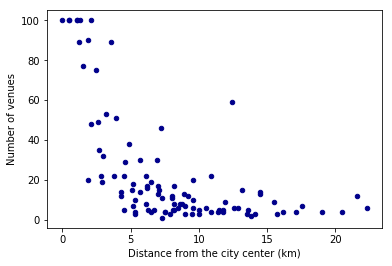

In [873]:
distance_vs_venues = dist_venues_1.plot.scatter(x='Distance', y='Venue',c='DarkBlue')

# Set the x-axis label
distance_vs_venues.set_xlabel("Distance from the city center (km)")

# Set the y-axis label
distance_vs_venues.set_ylabel("Number of venues")

In [642]:
venues_grouped.describe()

,Venue
count,100.000000
mean,23.320000
std,28.884262
min,1.000000
25%,5.000000
50%,12.000000
75%,22.000000
max,100.000000


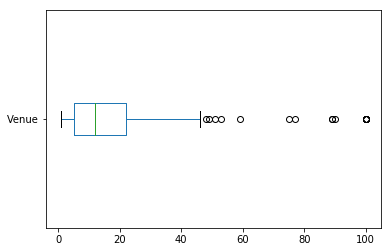

In [643]:
venues_grouped.plot.box(vert=False)

Let's remove all of the stations with 5 or less venues since it's most likely not enough to get reliable results. Those stations can be placed in their own "cluster" and are suitable for people who would like to move to a calm place with almost no venues.

In [653]:
calm_stations=venues_grouped
calm_stations.drop(calm_stations[calm_stations['Venue'] > 5].index, inplace=True)
calm_stations=calm_stations.drop('Venue',1)
calm_stations.head()
#calm_stations to create a "cluster" later, i.e. visualize this group on the map

,Metro station
0,Abrahamsberg
2,Alby
5,Axelsberg
9,Björkhagen
16,Enskede gård


In [654]:
sthlm_venues_2 = sthlm_venues_1.groupby('Metro station').filter(lambda x : len(x)>5)

In [655]:
print('There are {} uniques categories.'.format(len(sthlm_venues_2['Venue Category'].unique())))

There are 248 uniques categories.


In [656]:
sthlm_venues_2.shape

(2216, 7)

In [719]:
# one hot encoding
sthlm_onehot = pd.get_dummies(sthlm_venues_2[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
sthlm_onehot['Metro station'] = sthlm_venues_2['Metro station'] 

# move neighbourhood column to the first column
fixed_columns = [sthlm_onehot.columns[-1]] + list(sthlm_onehot.columns[:-1])
sthlm_onehot = sthlm_onehot[fixed_columns]

sthlm_onehot.head()

,Metro station,Accessories Store,Advertising Agency,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Burger Joint,Bus Line,Bus Station,Bus Stop,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Currency Exchange,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Doctor's Office,Dog Run,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,General College & University,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Lebanese Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Newsstand,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Pakistani Restaurant,Palace,Park,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Pub,Ramen Restaurant,Record Shop,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Slussen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [720]:
sthlm_onehot.shape

(2216, 249)

In [725]:
sthlm_grouped = sthlm_onehot.groupby('Metro station').mean().reset_index()
sthlm_grouped.head()

,Metro station,Accessories Store,Advertising Agency,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Burger Joint,Bus Line,Bus Station,Bus Stop,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Currency Exchange,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Doctor's Office,Dog Run,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,General College & University,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Lebanese Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Newsstand,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Pakistani Restaurant,Palace,Park,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Pub,Ramen Restaurant,Record Shop,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Akalla,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.076923,0.000000,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153846,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,

In [723]:
#sthlm_grouped

In [359]:
#sthlm_grouped=sthlm_grouped.replace(0, "")

In [371]:
#sthlm_grouped

In [369]:
#freq_venues_sorted=metro_stations_venues_sorted.drop(columns=['Cluster Labels','Metro station'])
#freq_venues_sorted.stack().value_counts()

Let's try to find optimal number of clusters using Elbow method:

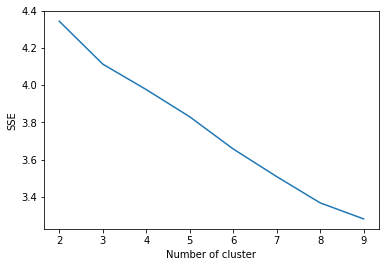

In [874]:
sthlm_grouped_clustering = sthlm_grouped.drop('Metro station', 1)

sse = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=1).fit(sthlm_grouped_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Let's use one more method for finding best number of clusters, calculating silhouette score. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [729]:
 #   kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=0).fit(sthlm_grouped_clustering)
for n_clusters in range(2, 10):
    clusterer = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=1)
    preds = clusterer.fit_predict(sthlm_grouped_clustering)
    centers = clusterer.cluster_centers_
    score = silhouette_score (sthlm_grouped_clustering, preds, metric='euclidean')
    print(n_clusters, score)

2 0.12316715084204051
3 0.15227602706965873
4 0.10611887807520817
5 0.011717501233572847
6 0.019248301349611033
7 0.12976112273636878
8 0.0833060903913728
9 0.13099455665249102


Both the Elbow method and silhuette score indicate that the optimal number of clusters are 3.

In [731]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sthlm_grouped_clustering)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:100] 

# Let's see how many stations belong to each cluster

from collections import Counter, defaultdict
print(Counter(kmeans.labels_))

Counter({2: 32, 0: 26, 1: 12})


To describe stations within each cluster, let's select top 5 most common venues for every station:

In [732]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Metro station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
metro_stations_venues_sorted = pd.DataFrame(columns=columns)
metro_stations_venues_sorted['Metro station'] = sthlm_grouped['Metro station']

for ind in np.arange(sthlm_grouped.shape[0]):
    metro_stations_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sthlm_grouped.iloc[ind, :], num_top_venues)
    
metro_stations_venues_sorted

,Metro station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Akalla,Farm,Convenience Store,Asian Restaurant,Pizza Place,Plaza
1,Alvik,Hotel,Pizza Place,Convenience Store,Italian Restaurant,Burger Joint
2,Aspudden,Pizza Place,Thai Restaurant,Grocery Store,Bakery,Golf Course
3,Bagarmossen,Pizza Place,Pharmacy,Scandinavian Restaurant,Grocery Store,Fast Food Restaurant
4,Bandhagen,Bus Station,Stadium,Hobby Shop,Convenience Store,Pizza Place
5,Bergshamra,Pizza Place,Bus Stop,Grocery Store,Gym / Fitness Center,Bakery
6,Blackeberg,Food & Drink Shop,Plaza,Gym / Fitness Center,Burger Joint,Thai Restaurant
7,Blåsut,Stadium,Pizza Place,Gym / Fitness Center,Bar,Thai Restaurant
8,Bredäng,Grocery Store,Pizza Place,Gym,Gym / Fitness Center,Performing Arts Venue
9,Brommaplan,Sushi Restaurant,Supermarket,Tennis Court,Liquor Store,Grocery Store


Let's add cluster labels to the table above and merge it with the table from Wikipedia that contains the coordinates:

Let's add stations with very few venues (5 or less) to the map:

In [733]:
calm_stations['Cluster Labels'] = kclusters
calm_stations = calm_stations.join(df4.set_index('Station'), on='Metro station')

In [734]:
# add clustering labels
metro_stations_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#sthlm_merged = df4

sthlm_merged = metro_stations_venues_sorted

# merge XXX toronto_grouped with XXX toronto_data to add latitude/longitude for each metro station
sthlm_merged = sthlm_merged.join(df4.set_index('Station'), on='Metro station')

#df_inner = pd.merge(df1, df2, on='id', how='inner')

#df_inner

sthlm_merged.head()

,Cluster Labels,Metro station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Longitude,Latitude
0,2,Akalla,Farm,Convenience Store,Asian Restaurant,Pizza Place,Plaza,17.912796,59.414814
1,2,Alvik,Hotel,Pizza Place,Convenience Store,Italian Restaurant,Burger Joint,17.980269,59.333633
2,2,Aspudden,Pizza Place,Thai Restaurant,Grocery Store,Bakery,Golf Course,18.001447,59.306449
3,1,Bagarmossen,Pizza Place,Pharmacy,Scandinavian Restaurant,Grocery Store,Fast Food Restaurant,18.131467,59.276263
4,2,Bandhagen,Bus Station,Stadium,Hobby Shop,Convenience Store,Pizza Place,18.049486,59.270403


In [735]:
#Finally let's add calm stations:
sthlm_merged = pd.concat([sthlm_merged, calm_stations], axis=0, ignore_index=True)
sthlm_merged

C:\Users\oxana_r7lkrla\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels,Latitude,Longitude,Metro station
0,Farm,Convenience Store,Asian Restaurant,Pizza Place,Plaza,2,59.414814,17.912796,Akalla
1,Hotel,Pizza Place,Convenience Store,Italian Restaurant,Burger Joint,2,59.333633,17.980269,Alvik
2,Pizza Place,Thai Restaurant,Grocery Store,Bakery,Golf Course,2,59.306449,18.001447,Aspudden
3,Pizza Place,Pharmacy,Scandinavian Restaurant,Grocery Store,Fast Food Restaurant,1,59.276263,18.131467,Bagarmossen
4,Bus Station,Stadium,Hobby Shop,Convenience Store,Pizza Place,2,59.270403,18.049486,Bandhagen
5,Pizza Place,Bus Stop,Grocery Store,Gym / Fitness Center,Bakery,1,59.381509,18.036514,Bergshamra
6,Food & Drink Shop,Plaza,Gym / Fitness Center,Burger Joint,Thai Restaurant,2,59.348357,17.882799,Blackeberg
7,Stadium,Pizza Place,Gym / Fitness Center,Bar,Thai Restaurant,1,59.290242,18.091061,Blåsut
8,Grocery Store,Pizza Place,Gym,Gym / Fitness Center,Performing Arts Venue,1,59.294835,17.933812,Bredäng
9,Sushi Restaurant,Supermarket,Tennis Court,Liquor Store,Grocery Store,2,59.338388,17.939260,Brommaplan


In [736]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters and add markers to the map

colors = ['red','green','blue','black']
fillers = ['red','green','blue','beige']

for lat, lon, poi, cluster in zip(sthlm_merged['Latitude'], sthlm_merged['Longitude'], sthlm_merged['Metro station'], sthlm_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=fillers[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [737]:
cluster_1=sthlm_merged.loc[sthlm_merged['Cluster Labels'] == 0, sthlm_merged.columns[[0] + list(range(1, sthlm_merged.shape[1]))]]
cluster_1

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels,Latitude,Longitude,Metro station
14,Bakery,Italian Restaurant,Japanese Restaurant,Coffee Shop,Indian Restaurant,0,59.332203,18.029188,Fridhemsplan
16,Scandinavian Restaurant,Café,Plaza,Pub,Bakery,0,59.323160,18.067617,Gamla stan
17,Nightclub,Gym / Fitness Center,Chinese Restaurant,Music Venue,General Entertainment,0,59.294278,18.077972,Globen
18,Coffee Shop,Concert Hall,Bakery,Park,Hockey Arena,0,59.299114,18.080768,Gullmarsplan
22,Italian Restaurant,Café,Bar,Playground,Chinese Restaurant,0,59.315834,18.034024,Hornstull
27,Gym / Fitness Center,Café,Scandinavian Restaurant,Clothing Store,Hotel,0,59.335529,18.063536,Hötorget
28,Pet Store,Dance Studio,Scandinavian Restaurant,Thrift / Vintage Store,Event Space,0,59.367944,17.857467,Johannelund
29,Italian Restaurant,Bakery,Thai Restaurant,French Restaurant,Scandinavian Restaurant,0,59.338810,18.090863,Karlaplan
30,Gym / Fitness Center,Middle Eastern Restaurant,Coffee Shop,Clothing Store,Asian Restaurant,0,59.402868,17.942433,Kista
32,Scandinavian Restaurant,Hotel,Clothing Store,Plaza,Park,0,59.330783,18.073298,Kungsträdgården


In [738]:
cluster_2=sthlm_merged.loc[sthlm_merged['Cluster Labels'] == 1, sthlm_merged.columns[[0] + list(range(1, sthlm_merged.shape[1]))]]
cluster_2

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels,Latitude,Longitude,Metro station
3,Pizza Place,Pharmacy,Scandinavian Restaurant,Grocery Store,Fast Food Restaurant,1,59.276263,18.131467,Bagarmossen
5,Pizza Place,Bus Stop,Grocery Store,Gym / Fitness Center,Bakery,1,59.381509,18.036514,Bergshamra
7,Stadium,Pizza Place,Gym / Fitness Center,Bar,Thai Restaurant,1,59.290242,18.091061,Blåsut
8,Grocery Store,Pizza Place,Gym,Gym / Fitness Center,Performing Arts Venue,1,59.294835,17.933812,Bredäng
11,Pizza Place,Athletics & Sports,Playground,Stadium,Pool,1,59.367891,17.964618,Duvbo
26,Grocery Store,Bakery,Scandinavian Restaurant,Convenience Store,Shopping Plaza,1,59.257925,18.082494,Hökarängen
40,Pizza Place,Trail,Bus Station,Grocery Store,Theater,1,59.243794,17.814526,Norsborg
46,Scandinavian Restaurant,Gym / Fitness Center,Pizza Place,Pool,Electronics Store,1,59.284785,18.092382,Sandsborg
49,Pizza Place,Grocery Store,Bus Stop,Japanese Restaurant,Fast Food Restaurant,1,59.266816,18.133346,Skarpnäck
52,Thai Restaurant,Plaza,Supermarket,Stadium,Bus Station,1,59.283302,18.070592,Sockenplan


In [739]:
cluster_3=sthlm_merged.loc[sthlm_merged['Cluster Labels'] == 2, sthlm_merged.columns[[0] + list(range(1, sthlm_merged.shape[1]))]]
cluster_3

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels,Latitude,Longitude,Metro station
0,Farm,Convenience Store,Asian Restaurant,Pizza Place,Plaza,2,59.414814,17.912796,Akalla
1,Hotel,Pizza Place,Convenience Store,Italian Restaurant,Burger Joint,2,59.333633,17.980269,Alvik
2,Pizza Place,Thai Restaurant,Grocery Store,Bakery,Golf Course,2,59.306449,18.001447,Aspudden
4,Bus Station,Stadium,Hobby Shop,Convenience Store,Pizza Place,2,59.270403,18.049486,Bandhagen
6,Food & Drink Shop,Plaza,Gym / Fitness Center,Burger Joint,Thai Restaurant,2,59.348357,17.882799,Blackeberg
9,Sushi Restaurant,Supermarket,Tennis Court,Liquor Store,Grocery Store,2,59.338388,17.939260,Brommaplan
10,Convenience Store,Bus Station,Restaurant,Light Rail Station,Bus Stop,2,59.391901,18.041368,Danderyds sjukhus
12,Supermarket,Fast Food Restaurant,Italian Restaurant,Gym / Fitness Center,Café,2,59.243552,18.093281,Farsta
13,Fast Food Restaurant,Gym,Burger Joint,Pizza Place,Bus Station,2,59.235012,18.101740,Farsta strand
15,Grocery Store,Convenience Store,Pizza Place,Fast Food Restaurant,Scandinavian Restaurant,2,59.285927,17.965005,Fruängen


In [740]:
cluster_4=sthlm_merged.loc[sthlm_merged['Cluster Labels'] == 3, sthlm_merged.columns[[0] + list(range(3, sthlm_merged.shape[1]))]]
cluster_4

,1st Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels,Latitude,Longitude,Metro station
70,NaN,NaN,NaN,3,59.336680,17.952950,Abrahamsberg
71,NaN,NaN,NaN,3,59.239498,17.845332,Alby
72,NaN,NaN,NaN,3,59.304364,17.974920,Axelsberg
73,NaN,NaN,NaN,3,59.291114,18.115520,Björkhagen
74,NaN,NaN,NaN,3,59.289397,18.070296,Enskede gård
75,NaN,NaN,NaN,3,59.247462,17.860964,Fittja
76,NaN,NaN,NaN,3,59.262879,18.082036,Gubbängen
77,NaN,NaN,NaN,3,59.262726,18.012486,Hagsätra
78,NaN,NaN,NaN,3,59.294763,18.104554,Hammarbyhöjden
79,NaN,NaN,NaN,3,59.396171,17.887716,Hjulsta


In [309]:
cluster_5=sthlm_merged.loc[sthlm_merged['Cluster Labels'] == 4, sthlm_merged.columns[[0] + list(range(3, sthlm_merged.shape[1]))]]
cluster_5

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue


In [310]:
cluster_6=sthlm_merged.loc[sthlm_merged['Cluster Labels'] == 5, sthlm_merged.columns[[0] + list(range(3, sthlm_merged.shape[1]))]]
cluster_6

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue


In [741]:
c_1=cluster_1.drop(columns=['Cluster Labels','Metro station','Longitude','Latitude'])
c_1.stack().value_counts()

Scandinavian Restaurant      16
Café                         14
Bakery                        9
Italian Restaurant            7
Clothing Store                6
Hotel                         6
Coffee Shop                   6
Bar                           5
Thai Restaurant               5
Restaurant                    4
Indian Restaurant             4
Gym / Fitness Center          4
Pub                           3
Cocktail Bar                  3
Pizza Place                   2
Sushi Restaurant              2
Chinese Restaurant            2
Record Shop                   2
Park                          2
Asian Restaurant              2
Plaza                         2
Hotel Bar                     1
Thrift / Vintage Store        1
Sandwich Place                1
Bowling Alley                 1
Ice Cream Shop                1
General Entertainment         1
Gym                           1
Beer Bar                      1
Japanese Restaurant           1
Bus Station                   1
Hockey A

In [742]:
c_2=cluster_2.drop(columns=['Cluster Labels','Metro station','Longitude','Latitude'])
c_2.stack().value_counts()

Pizza Place                10
Grocery Store               7
Bakery                      4
Gym / Fitness Center        4
Scandinavian Restaurant     3
Thai Restaurant             3
Stadium                     3
Bus Stop                    2
Plaza                       2
Bus Station                 2
Fast Food Restaurant        2
Pool                        2
Electronics Store           2
Playground                  1
Shopping Plaza              1
Pharmacy                    1
Park                        1
Gym                         1
Supermarket                 1
Pub                         1
Bar                         1
Convenience Store           1
Athletics & Sports          1
Theater                     1
Performing Arts Venue       1
Trail                       1
Japanese Restaurant         1
dtype: int64

In [743]:
c_3=cluster_3.drop(columns=['Cluster Labels','Metro station','Longitude','Latitude'])
c_3.stack().value_counts()

Pizza Place                  11
Grocery Store                10
Gym / Fitness Center          9
Café                          9
Convenience Store             8
Thai Restaurant               7
Bus Station                   6
Sushi Restaurant              6
Supermarket                   6
Burger Joint                  5
Restaurant                    4
Fast Food Restaurant          4
Plaza                         4
Shopping Mall                 4
Bakery                        3
Italian Restaurant            3
Park                          3
Bus Stop                      3
Indian Restaurant             3
Hotel                         3
Asian Restaurant              3
Light Rail Station            2
Japanese Restaurant           2
Tennis Court                  2
Liquor Store                  2
Clothing Store                2
Kebab Restaurant              2
Gas Station                   1
Food & Drink Shop             1
Lounge                        1
Gym                           1
Athletic

In [578]:
c_4=cluster_4.drop(columns=['Cluster Labels','Station'])
c_4.stack().value_counts()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue


In [592]:
#kmeans_cluster_centers = kmeans.cluster_centers_
#kmeans_cluster_centers